In [1]:
import sys
sys.path.append("./../common/")
from utils import *
from config import *

# configuring tensorflow to be deterministic for reproducibility
tf.keras.utils.set_random_seed(RND_SEED)
tf.config.experimental.enable_op_determinism()

In [2]:
def prior_with_scale(scale):
    def prior(kernel_size, bias_size=0, dtype=None):
        n = kernel_size + bias_size
        return tf.keras.Sequential([
            tfp.layers.VariableLayer(n, dtype=dtype),
            tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=scale))
        ])
    return prior

def build_train_NN(x_train, y_train, epochs, prior_scale=1, lr=1e-3):
    # build NN
    z = np.log(np.expm1(1.))
    model = tf.keras.models.Sequential([
        tfp.layers.DenseVariational(units=2,
                            make_prior_fn=prior_with_scale(prior_scale),
                            make_posterior_fn=common_posterior,
                            kl_weight=1/x_train.size,
                            kl_use_exact=False),
        tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.Normal(loc=t[..., :1],
                                    scale=1e-3 + 0.1*tf.nn.softplus(z + t[..., 1:])
                                    )
                )
    ])

    model.compile(loss=nll, optimizer=tf.optimizers.Adam(learning_rate=lr))

    # train NN
    history = model.fit(x_train, y_train, epochs=epochs, verbose=0)
    return model, history.history['loss']

def get_NN_output(model, x, K):
    means = []
    vars = []
    for _ in range(K):
        sample_output = model(x)
        means.append(np.squeeze(sample_output.mean()))
        vars.append(np.squeeze(sample_output.variance()))
    
    y_hat = np.array(means).mean(axis=0)
    sd_hat = np.sqrt(np.array(means).var(axis=0) + np.array(vars).mean(axis=0))
    return y_hat, sd_hat

def plot_NN_ci(model, name, x, y, K, x_train, y_train):
    # make predictions
    y_hat, sd_hat = get_NN_output(model, x, K)

    # calculate and plot CI
    ci_lower = y_hat - 2 * sd_hat
    ci_upper = y_hat + 2 * sd_hat

    fig = plt.figure()
    plt.scatter(x, y, label='{} points'.format(name), s=1)
    plt.scatter(x, y_hat, label='BNN predictions', c='r')
    plt.fill_between(np.squeeze(x), np.squeeze(ci_lower), np.squeeze(ci_upper), alpha=.2, label='$\pm\,2\hat\sigma$ CI (BNN)')
    plot_NN_expected_unc(y_hat, x, y, K, x_train, y_train)
    return fig

def create_dataset(N):
    m, c = 0.2, 0.1
    sd_e = 0.02

    x_train = np.linspace(0, 0.5, N)[:, np.newaxis]
    y_train = m*(x_train + np.random.normal(0, sd_e, N).reshape(-1, 1)) + c
    x_test = np.linspace(0.5, 1, N)[:, np.newaxis]
    y_test = m*(x_test + np.random.normal(0, sd_e, N).reshape(-1, 1)) + c

    return x_train, y_train, x_test, y_test

def plot_NN_expected_unc(preds, x, y, K, x_train, y_train):
    x, y = x.flatten(), y.flatten()
    x_train, y_train = x_train.flatten(), y_train.flatten()
    N = x.size
    def least_squares(x, y):
        phi = np.vstack([x, np.ones(N)]).T
        y = y[:, np.newaxis]

        w = np.dot((np.dot(np.linalg.inv(np.dot(phi.T, phi)), phi.T)),y)
        return tuple(w.squeeze())

    # calculating data uncertainty using least squares
    m_hat, c_hat = least_squares(x_train, y_train)
    y_hat = (m_hat * x) + c_hat
    sd_data = np.std(y - y_hat)
    
    # calculating model uncertainty using bayesian treatment
    alpha = sd_data
    beta = 1/alpha**2
    phi = np.vstack([x_train, np.ones(N)]).T
    y_train = y_train[:, np.newaxis]
    I = np.identity(2)
    SN_inv = (alpha * I) + (beta * np.dot(phi.T, phi))
    SN = np.linalg.inv(SN_inv)
    mN = beta * np.dot(np.dot(SN, phi.T), y_train)
    
    m_hat, c_hat = tuple(mN.squeeze())
    sd_m, sd_c = np.sqrt(np.diag(SN))
    y_hats = []
    for _ in range(K):
        y_hat = (m_hat + np.random.normal(0, sd_m)) * x + (c_hat + np.random.normal(0, sd_c))
        y_hats.append(y_hat)
    sd_model = np.var(np.asarray(y_hats).squeeze(), 0)
    
    sd_combined = sd_data + sd_model

    # calculate and plot CI
    ci_lower = preds - 2 * sd_combined
    ci_upper = preds + 2 * sd_combined

    plt.plot(x, ci_lower, '--', c="black", label="$\pm\,2\hat\sigma$ CI (OLS)")
    plt.plot(x, ci_upper, '--', c="black")

def plot_calibration_with_prior_scale(scale, epochs, filename, lr=1e-3):
    Ns = [10, 50, 100, 5000]
    fig = plt.figure()
    plt.plot([0,100], [0,100], label="ideal", c="black")

    confidences = get_confidence_axis()
    for N in Ns:
        x_train, y_train, x_test, y_test = create_dataset(N)
        model, _ = build_train_NN(x_train, y_train, epochs, prior_scale=scale, lr=lr)
        y_hat, sd_hat = get_NN_output(model, x_test, K)
        in_range = unc_calibration(y_test, y_hat, sd_hat)
        plt.plot(confidences, in_range, label="{} training points".format(N))

    save_xy_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, filename)

def plot_all_K_NN(model, name, x, y, K, x_train, y_train):
    # make predictions
    means = []
    vars = []
    for _ in range(K):
        sample_output = model(x)
        means.append(np.squeeze(sample_output.mean()))
        vars.append(np.squeeze(sample_output.variance()))
    
    y_hat = np.array(means).mean(axis=0)
    sd_hat = np.sqrt(np.array(means).var(axis=0) + np.array(vars).mean(axis=0))

    # calculate and plot CI
    ci_lower = y_hat - 2 * sd_hat
    ci_upper = y_hat + 2 * sd_hat

    fig = plt.figure()
    plt.plot(x, means[0], label='BNN predictions from K instances', c='r', linewidth=0.25)
    for i in range(1,K):
        plt.plot(x, means[i], c='r', linewidth=0.25)
    plt.scatter(x, y, label='{} points'.format(name), s=1)
    plt.fill_between(np.squeeze(x), np.squeeze(ci_lower), np.squeeze(ci_upper), alpha=.2, label='$\pm\,2\hat\sigma$ CI (BNN)')
    plot_NN_expected_unc(y_hat, x, y, K, x_train, y_train)
    return fig

2023-03-31 23:31:52.279838: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


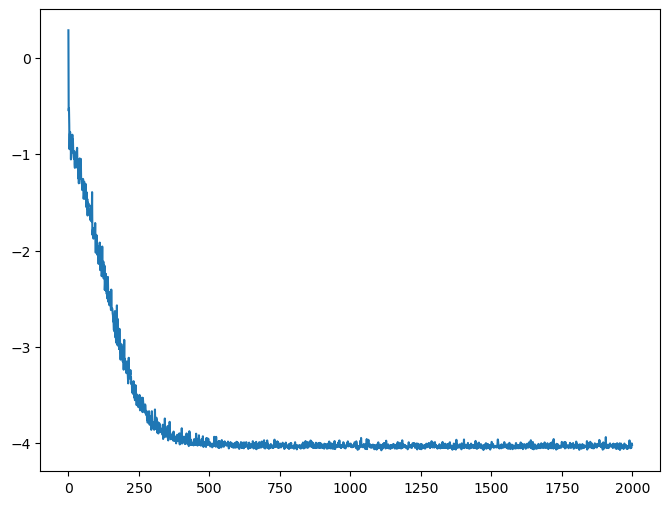

In [3]:
K = 100
x_train, y_train, x_test, y_test = create_dataset(1000)

model, loss = build_train_NN(x_train, y_train, 2000)
plt.plot(loss)
plt.show()

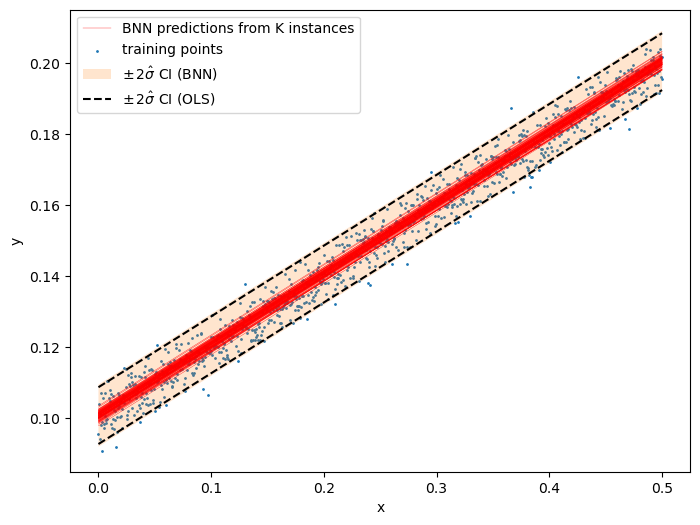

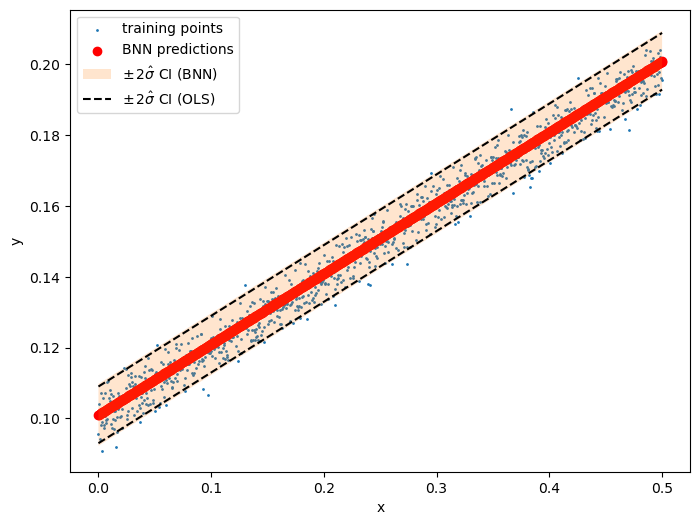

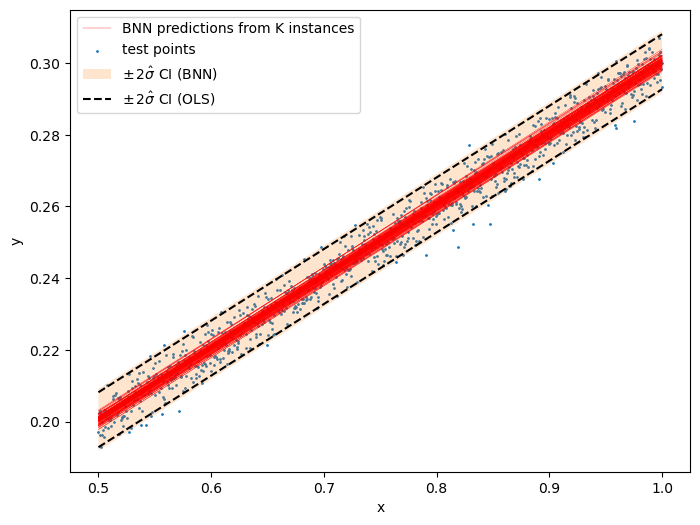

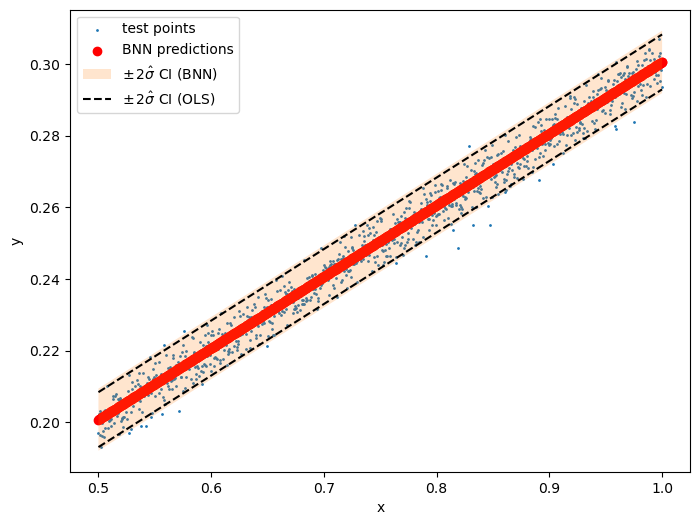

In [4]:
fig = plot_all_K_NN(model, 'training', x_train, y_train, K,  x_train, y_train)
save_xy_graph(fig, "x", "y", figures_dir, 'bnn_ci_train.png')
fig = plot_NN_ci(model, 'training', x_train, y_train, K,  x_train, y_train)
save_xy_graph(fig, "x", "y", figures_dir, 'bnn_ci_train.png')

fig = plot_all_K_NN(model, 'test', x_test, y_test, K,  x_train, y_train)
save_xy_graph(fig, "x", "y", figures_dir, 'bnn_ci_test.png')
fig = plot_NN_ci(model, 'test', x_test, y_test, K,  x_train, y_train)
save_xy_graph(fig, "x", "y", figures_dir, 'bnn_ci_test.png')

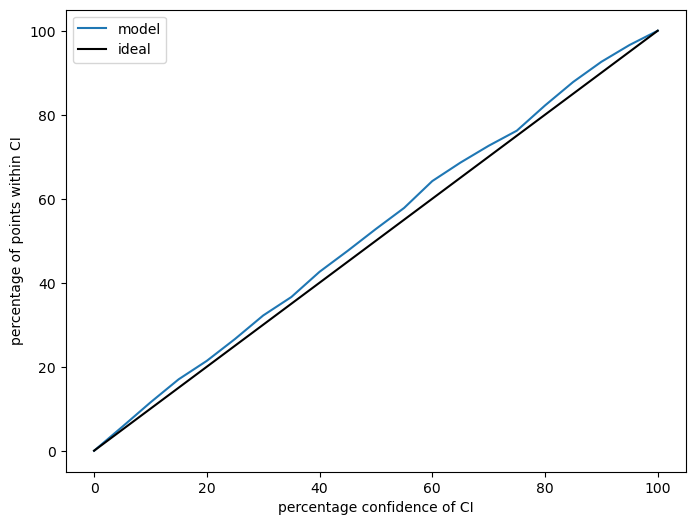

In [5]:
y_hat, sd_hat = get_NN_output(model, x_train, K)
in_range = unc_calibration(y_train, y_hat, sd_hat)
fig = plt.figure()
plt.plot(get_confidence_axis(), in_range, label="model")
plt.plot([0,100], [0,100], label="ideal", c="black")
save_xy_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, 'bnn_calibration.png')

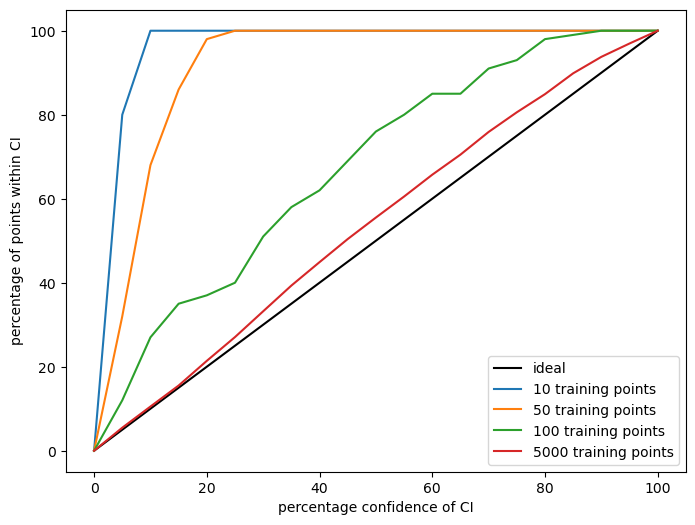

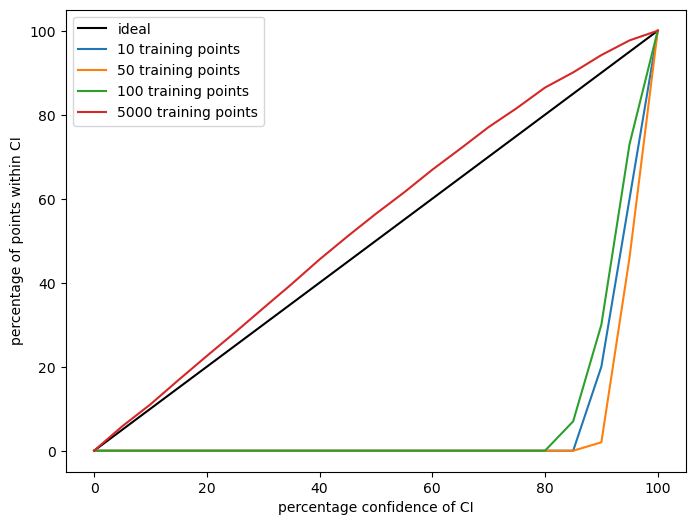

In [6]:
plot_calibration_with_prior_scale(1, 2000, 'bnn_N_calibration_wide.png')
plot_calibration_with_prior_scale(0.001, 10000, 'bnn_N_calibration_narrow.png', lr=1e-4)